<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Homeworks/HW9_Azzarano_Nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
April 7, 2025

#Homework 9: Neural Network by Hands
In this homework, you will work on the classification task with three synthetical datasets: Noisy Moons, Noisy Circles, and a multipetal rose.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from mlxtend.plotting import plot_decision_regions

In [3]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [4]:
x, y = load_planar_dataset()  #make_moons(n_samples=200, noise=0.1)  make_circles(n_samples=200, noise=0.1)
y = y.reshape(-1,1)
x.shape, y.shape

((400, 2), (400, 1))

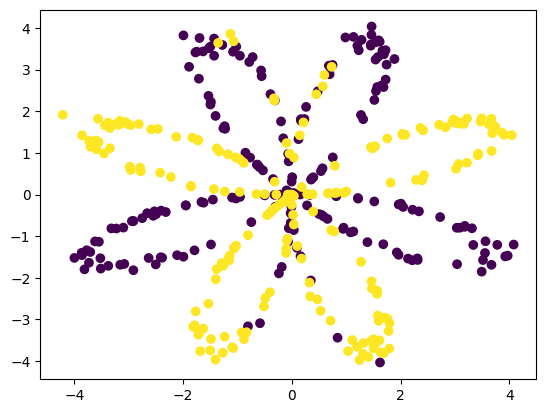

In [5]:
plt.scatter(x[:,0], x[:,1], c=y)

Below is the model from the class: $x\to h\to a=\sigma(h)\to o\to Loss(o,y)$, where $Loss$ is MSE:
$$
Loss(o,y) = \frac{1}{N} \sum_{i=1}^{N}\left( o^{(i)}-y^{(i)}\right)^2.
$$

For the binary classification we use binary cross-entropy loss:
$$
Loss(\sigma(o^{(i)}),y^{(i)}) = -\frac{1}{N}\sum_{i=1}^{N}\left( y^{(i)}\log \sigma(o^{(i)}) + (1-y^{(i)})\log\left( 1-\sigma(o^{(i)})\right) \right)
$$

##Q1 (2pt). Change the model class, applying activation to the output:
$x\to h\to a=\sigma(h)\to o\to \sigma(o) \to Loss(\sigma(o),y)$

##Q2 (5pt). Modify the loss class: the function and the derivative.

To avoid devision by zero, add `self.eps = 1e-6`:
$$
Loss(\sigma(o^{(i)}),y^{(i)}) = -\frac{1}{N}\sum_{i=1}^{N}\left( y^{(i)}\log (\sigma(o^{(i)})+\varepsilon) + (1-y^{(i)})\log\left( 1-\sigma(o^{(i)})+\varepsilon\right) \right)
$$

##Q3 (2pt). Change the `predict` method to return $0$ or $1$ instead of $\sigma(o)$.

##Q4 (9pt). Create 3 models for every dataset with sizes of the hidden layer 3, 5, and 10 (9 models in total). You may want to run `.fit` several times with different parameters of `lr` and `n_epochs` to get good separation.
Expected code is provided after the model.

##Q5 (2pt). Comment on the behavior of the loss function, did you see some jumps (usually with high learning rate), drops, oscillations, etc. Could you explain this? Is the loss function convex with respect to the weights $W$ and baias $b$?

In [6]:
class Loss():
  def __init__(self):
    self.x_in = None
    self.y_in = None
    self.eps = 1e-6  # To avoid division by zero -- Q2

  def forward(self, x_in, y_in):
    """
    Compute the binary cross-entropy loss:
    Loss = -1/N * sum(y*log(x) + (1-y)*log(1-x))
    Q2
    """
    self.x_in = x_in
    self.y_in = y_in
    return -np.mean(
        y_in * np.log(x_in + self.eps) + (1 - y_in) * np.log(1 - x_in + self.eps)
    )

  def backward(self):
    """
    Compute the gradient of the binary cross-entropy loss with respect to x_in:
    dLoss/dx = -(y/x - (1-y)/(1-x)) / N
    Q2
    """
    return -(self.y_in / (self.x_in + self.eps) - (1 - self.y_in) / (1 - self.x_in + self.eps)) / len(self.x_in)

In [7]:
class Activation():
  def __init__(self):
    self.x_in = None

  def forward(self, x_in):
    self.x_in = x_in
    return 1/(1+np.exp(-self.x_in))

  def backward(self, grad, lr=1e-3):
    return grad* np.exp(self.x_in)/(1+np.exp(self.x_in))**2

In [8]:
class Linear():
  def __init__(self, input_size, output_size):
    self.W = np.random.random((output_size, input_size))*0.01
    self.b = np.random.random((output_size, 1))*0.01

    self.grad_W = np.zeros(self.W.shape)
    self.grad_b = np.zeros(self.b.shape)

    self.x_in = None

  def forward(self, x_in):
    self.x_in = x_in
    return (self.W.dot(self.x_in.T) + self.b).T

  def backward(self, grad, lr=1e-3):
    self.grad_W = grad.T @ self.x_in
    self.grad_b = grad.T @ np.ones((len(self.x_in),1))
    grad = grad @ self.W
    self.W -= lr * self.grad_W
    self.b -= lr * self.grad_b
    return grad

In [9]:
class MyNN():
  def __init__(self, input_size=1, hidden_size=3, output_size=1) -> None:
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.model = [
        Linear(self.input_size, self.hidden_size),
        Activation(),
        Linear(self.hidden_size, self.output_size),
        Activation()  # New activation layer -- Q1
    ]
    self.loss = Loss()

  def fit(self, x, y, lr=0.01, n_epoch=1000, warm_start=True):
    self.loss_array = []
    self.lr = lr
    self.n_epoch = n_epoch
    if not warm_start:
      # Reinitialize the model with the new structure
      self.model = [
          Linear(self.input_size, self.hidden_size),
          Activation(),
          Linear(self.hidden_size, self.output_size),
          Activation()  # New activation layer -- Q1
      ]
      self.loss = Loss()
    for epoc in range(1, self.n_epoch):
      x_in = x
      y_in = y
      for m in self.model:
        x_in = m.forward(x_in)
      self.loss_array.append(self.loss.forward(x_in, y_in))
      grad = self.loss.backward()
      for i in range(len(self.model)-1, -1, -1):
        grad = self.model[i].backward(grad, lr=self.lr)

  def predict(self, x):
      x_in = x.reshape(len(x), -1)
      for m in self.model:
        x_in = m.forward(x_in)
      return (x_in >= 0.5).astype(int)  # Return 0 or 1 based on threshold -- Q3



---



# Models for Planar Dataset

Model 1 : `hidden_size = 5`

In [10]:
model_1 = MyNN(input_size=2, hidden_size=5, output_size=1)

In [11]:
model_1.fit(x, y, lr=0.1, n_epoch=30000)

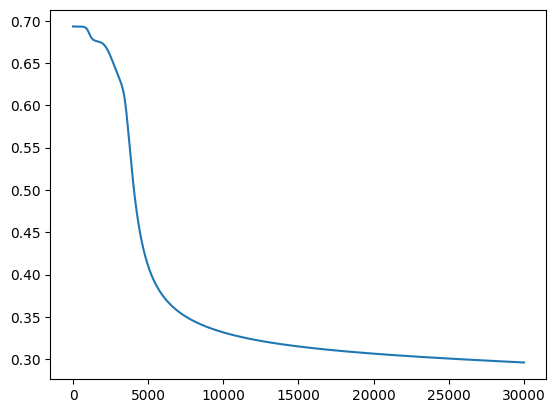

In [12]:
plt.plot(model_1.loss_array)

<Axes: >

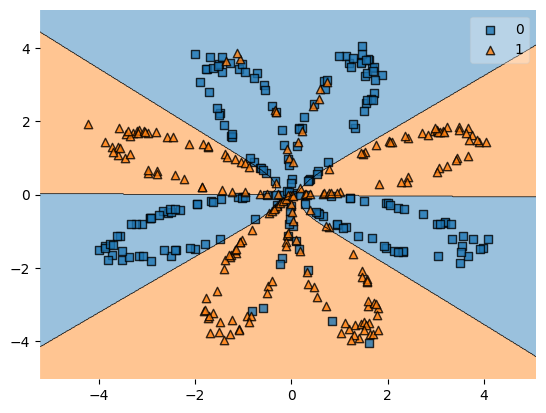

In [13]:
plot_decision_regions(x,y.reshape(-1,),model_1)

Model 2 : `hidden_size = 3`

In [22]:
model_2 = MyNN(input_size=2, hidden_size=3, output_size=1)

In [23]:
model_2.fit(x, y, lr=0.1, n_epoch=30000)

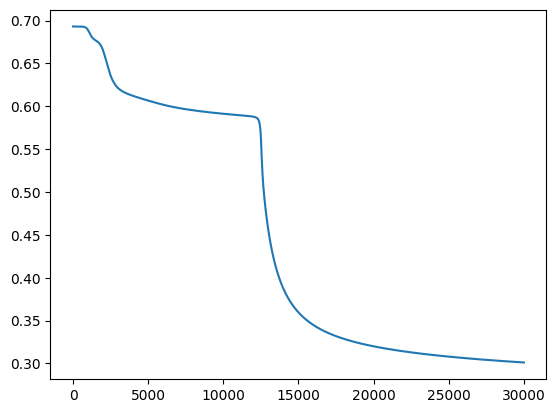

In [24]:
plt.plot(model_2.loss_array)

<Axes: >

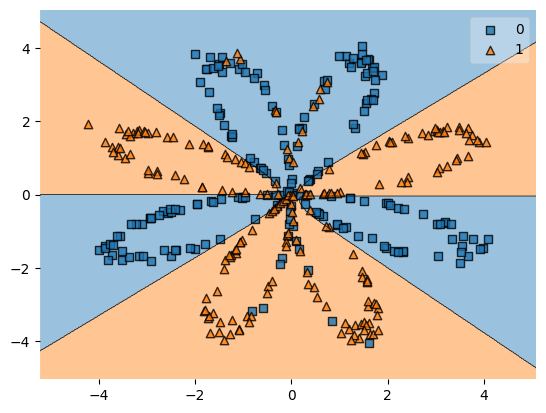

In [25]:
plot_decision_regions(x,y.reshape(-1,),model_2)

Model 3 : `hidden_size = 10`

In [26]:
model_3 = MyNN(input_size=2, hidden_size=10, output_size=1)

In [27]:
model_3.fit(x, y, lr=0.1, n_epoch=30000)

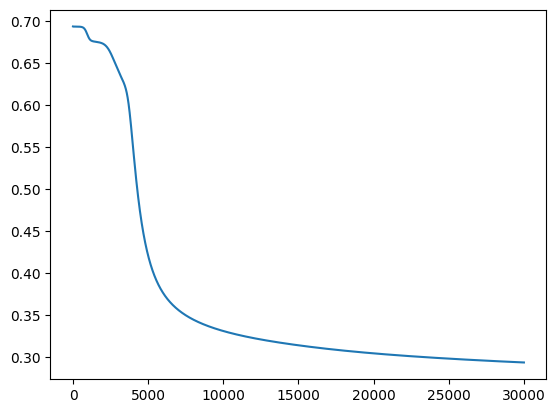

In [28]:
plt.plot(model_3.loss_array)

<Axes: >

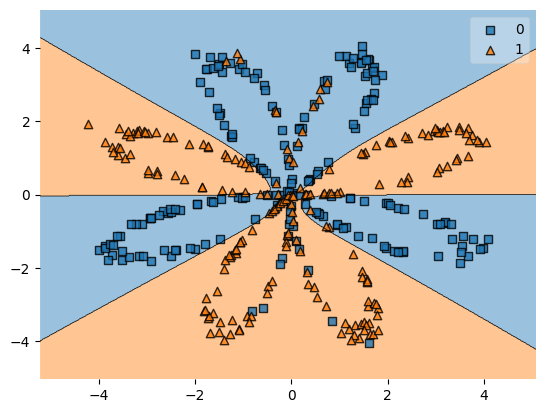

In [29]:
plot_decision_regions(x,y.reshape(-1,),model_3)



---


# Models for Moons Dataset

In [14]:
x_moons, y_moons = make_moons(n_samples=200, noise=0.1)  #load_planar_dataset()  make_circles(n_samples=200, noise=0.1)
y_moons = y_moons.reshape(-1,1)
x_moons.shape, y_moons.shape

((200, 2), (200, 1))

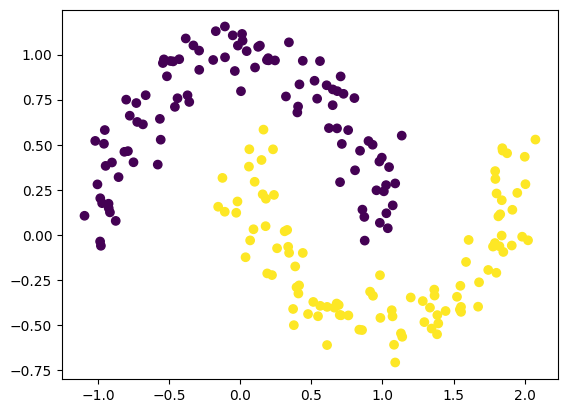

In [15]:
plt.scatter(x_moons[:,0], x_moons[:,1], c=y_moons)

Moons_Model 1 : `hidden_size = 3`

This one looks good after running `.fit` 3 times

In [30]:
moons_model_1 = MyNN(input_size=2, hidden_size=3, output_size=1)

In [37]:
moons_model_1.fit(x_moons, y_moons, lr=0.1, n_epoch=30000)

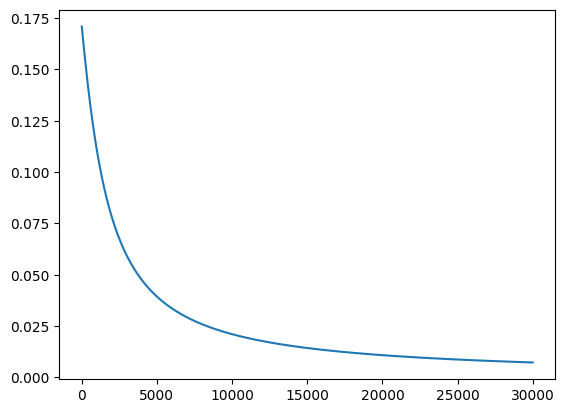

In [38]:
plt.plot(moons_model_1.loss_array)

<Axes: >

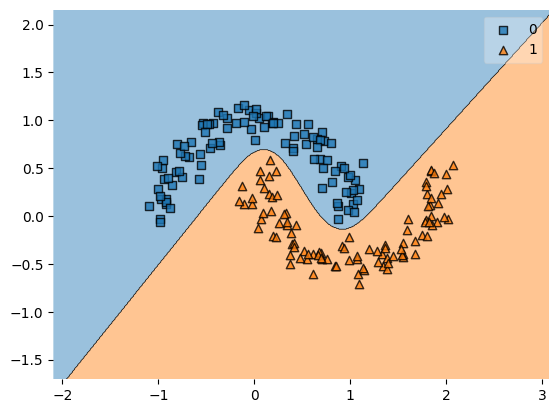

In [39]:
plot_decision_regions(x_moons,y_moons.reshape(-1,),moons_model_1)

Moons_Model 2 : `hidden_size = 5`

This one also looks good after running `.fit` 3 times

In [40]:
moons_model_2 = MyNN(input_size=2, hidden_size=5, output_size=1)

In [47]:
moons_model_2.fit(x_moons, y_moons, lr=0.1, n_epoch=30000)

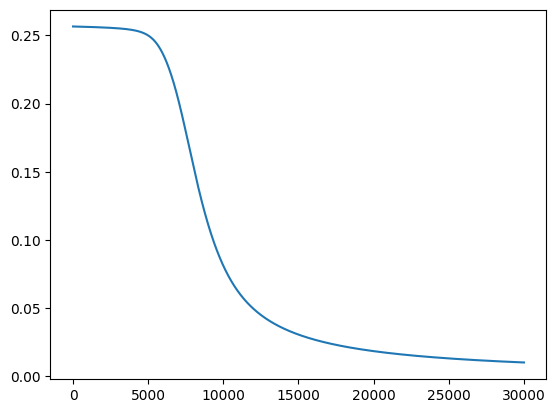

In [48]:
plt.plot(moons_model_2.loss_array)

<Axes: >

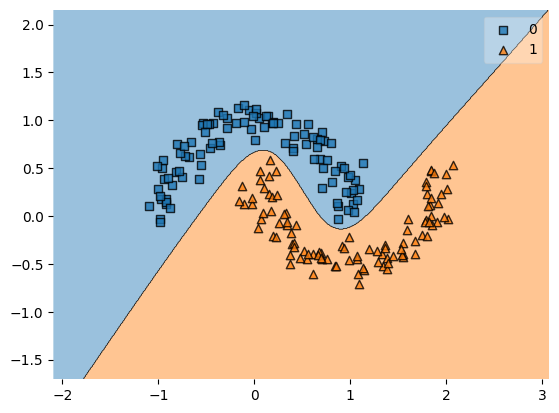

In [49]:
plot_decision_regions(x_moons,y_moons.reshape(-1,),moons_model_2)

Moons_Model 3 : `hidden_size = 10`

This needef 5 runs of `.fit` to look good.

In [50]:
moons_model_3 = MyNN(input_size=2, hidden_size=5, output_size=1)

In [63]:
moons_model_3.fit(x_moons, y_moons, lr=0.1, n_epoch=30000)

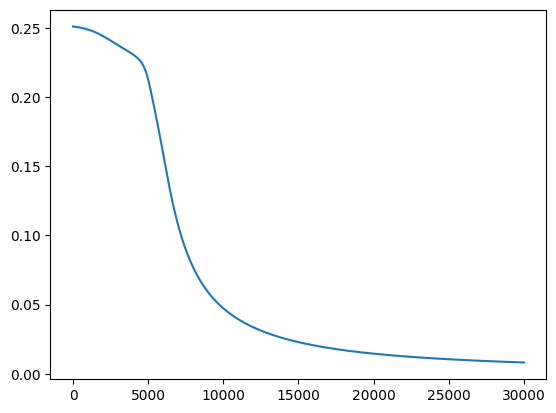

In [64]:
plt.plot(moons_model_3.loss_array)

<Axes: >

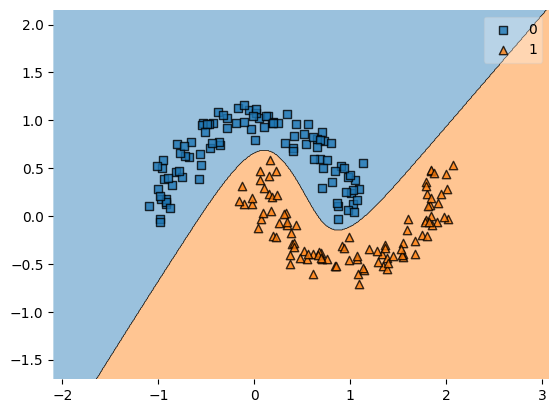

In [65]:
plot_decision_regions(x_moons,y_moons.reshape(-1,),moons_model_3)



---


# Models for Circles Dataset

In [16]:
x_circles, y_circles = make_circles(n_samples=200, noise=0.1)  #make_moons(n_samples=200, noise=0.1)  #load_planar_dataset()
y_circles = y_circles.reshape(-1,1)
x_circles.shape, y_circles.shape

((200, 2), (200, 1))

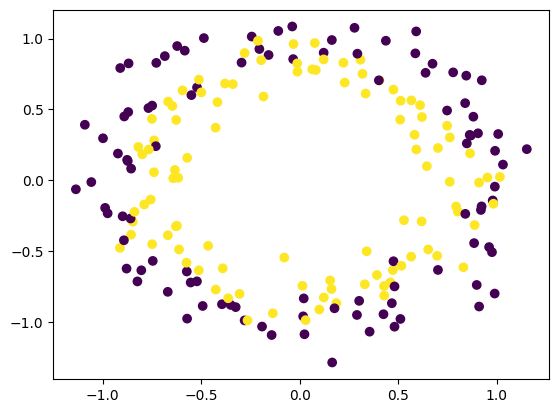

In [17]:
plt.scatter(x_circles[:,0], x_circles[:,1], c=y_circles)